# Neural network based integrator

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from models import *
import auxilliary
import json
import os, shutil
%matplotlib inline

np.random.seed(2512517)

## Neural network integrators
Let $q(t)=(x(t),v(t))\in\mathbb{R}^{2d}$ be the state vector. Two methods are implemented to advance this state vector in time:

### Multistep neural network
The `MultistepNNInetgrator` class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction. The neural network $\Phi$ can take different form:
* it can simply be a set of dense layers or
* it can be a two-layer LSTM network, followed by a dense layer as in [https://arxiv.org/abs/2004.06493](https://arxiv.org/abs/2004.06493)

### Hamiltonian neural network integrator
Alternatively, the `HamiltonianNNIntegrator` implements a single-step Stoermer-Verlet method for a Hamiltonian system, following the ideas in [https://arxiv.org/abs/1906.01563](https://arxiv.org/abs/1906.01563). In this case the update $q^{(t)}\mapsto q^{(t+\Delta t)}$ takes the form:

$$
\begin{aligned}
v^{(t+\Delta t/2)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t)}\right)\\[1ex]
x^{(t+\Delta t)} &= x^{(t)} + \Delta t \frac{\partial T}{\partial v}\left(v^{(t+\Delta t/2)}\right)\\[1ex]
v^{(t+\Delta t)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t+\Delta t)}\right)
\end{aligned}
$$

Assuming that the Hamiltonian $H(x,v) = T(v) + V(x)$ is separable, the kinetic energy $T(v)$ and potential energy $V(x)$ are represented by neural networks.

In [27]:
class NNIntegrator(object):
    '''Base class for neural network based integrators
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: number of multisteps
    '''
    def __init__(self,dynamical_system,dt,nsteps):
        self.dynamical_system = dynamical_system
        self.dt = dt        
        self.dim = 2*self.dynamical_system.dim
        self.nsteps = nsteps
        self.xv = np.zeros((1,self.nsteps,self.dim))
        
    @classmethod
    def from_model(cls,dynamical_system,dt,model):
        '''Construct integrator from model
        
        :arg dynamical_system: underlying dynamical system
        :arg dt: timestep size
        :arg model: neural network model
        '''
        nsteps = model.input_shape[1]
        nn_integrator = cls(dynamical_system,dt,nsteps)
        nn_integrator.model = model
        return nn_integrator
    
    def set_state(self,x,v):
        '''Set the current state of the integrator
        
        :arg x: Array of size nsteps x dim with initial positions
        :arg v: Array of size nsteps x dim with initial velocities
        '''
        self.xv[0,:,:self.dim//2] = x[:,:]
        self.xv[0,:,self.dim//2:] = v[:,:]
        
    @property
    def x(self):
        '''Return the current position vector (as a d-dimensional array)'''
        return self.xv[0,-1,:self.dim//2]

    @property
    def v(self):
        '''Return the current velocity vector (as a d-dimensional array)'''
        return self.xv[0,-1,self.dim//2:]
    
    def integrate(self,n_steps):
        '''Carry out a given number of integration steps
        
        :arg n_steps: number of integration steps
        '''
        for k in range(n_steps):
            x_pred = np.asarray(self.model.predict(self.xv)).flatten()
            self.xv = np.roll(self.xv, -1, axis=1)
            self.xv[0,-1,:] = x_pred[:]
            
    def energy(self):
        return self.dynamical_system.energy(self.x,self.v)

class MultistepNNIntegrator(NNIntegrator):
    '''Multistep integrator. Use a neural network to predict the next state, given
    a number of previous states
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: Number of steps of the timestepping method
    :arg dense_layers: neural network layers used to predict the next state
    '''
    def __init__(self,dynamical_system,dt,nsteps,dense_layers):
        super().__init__(dynamical_system,dt,nsteps)
        self.dim = 2*self.dynamical_system.dim
        self.dense_layers = dense_layers
        # Build model
        inputs = keras.Input(shape=(self.nsteps,self.dim))
        q_n = tf.unstack(inputs,axis=1)[-1]        
        output_layer = keras.layers.Dense(self.dim)
        x = inputs
        for layer in dense_layers:
            x = layer(x)
        x = output_layer(x)
        x = keras.layers.Rescaling(self.dt)(x)
        outputs = keras.layers.Add()([q_n,x])
        self.model = keras.Model(inputs=inputs,outputs=outputs)
        lr_schedule = keras.optimizers.schedules.CosineDecay(
                        initial_learning_rate=1e-3,
                        decay_steps=1000*1000,
                        alpha=1.E-3)
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def call(self, inputs, training=False):
        '''Evaluate model
        
        Split the inputs = (q_n,p_n) into position and momentum and 
        return the state (q_{n+1},p_{n+1}) at the next timestep.
        
        Note that the expected tensor shape is B x 1 x 2d to be compatible with
        the non-symplectic update 
        
        :arg inputs: state (q_n,p_n) as a B x 1 x 2d tensor
        '''
        
        input_shape = tf.shape(inputs)
        # Extract q_n and p_n from input
        qp_old = tf.unstack(tf.reshape(inputs, (input_shape[0],input_shape[2],)),axis=-1)
        q_old = tf.stack(qp_old[:self.dim//2],axis=-1)
        p_old = tf.stack(qp_old[self.dim//2:],axis=-1)
        q_new, p_new = self.verlet_step(q_old,p_old)        
        # Combine result of Verlet step into tensor of correct size
        outputs = tf.stack([q_new,p_new],axis=-1)        
        return outputs

class HamiltonianNNIntegrator(NNIntegrator):
    '''Neural network integrator based on the Hamiltonian Stoermer-Verlet update'''
    def __init__(self,dynamical_system,dt,V_pot_layers,T_kin_layers):
        super().__init__(dynamical_system,dt,1)
        self.V_pot_layers = V_pot_layers
        self.T_kin_layers = T_kin_layers
        self.model = self.build_model(self.dim,self.dt,self.V_pot_layers,self.T_kin_layers)
    
    @staticmethod
    def build_model(dim,dt,V_pot_layers,T_kin_layers,V_pot_layer_weights=None,T_kin_layer_weights=None):
        '''Build underlying Verlet model
        
        :arg dim: dimension of dynamical system
        :arg dt: timestep size
        :arg V_pot_layers: Layers used for potential energy network
        :arg T_kin_layers: Layers used for kinetic energy network
        :arg V_pot_layer_weights: list of layer weights for potential energy network
        :arg T_kin_layer_weights: list of layer weights for kinetic energy network
        '''        
        inputs = keras.Input(shape=(1,dim))
        verlet_model = VerletModel(dim,dt,
                                   V_pot_layers,
                                   T_kin_layers)
        outputs = verlet_model(inputs)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.build(input_shape=(None,1,dim))
        verlet_model.set_weights(V_pot_layer_weights,T_kin_layer_weights)        
        lr_schedule = keras.optimizers.schedules.CosineDecay(
                        initial_learning_rate=1e-3,
                        decay_steps=1000*1000,
                        alpha=1.E-3)
        model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
        return model
    
    def save_layers(self,layers,final_layer,filename):
        '''Save list of layers in a given file
        
        :arg layers: list of (intermediate) layers to save
        :arg final_layer: final layer to save (only weights)
        :arg filename: name of file to save to
        '''
        layer_list = []
        for layer in layers: 
            layer_list.append({'class':type(layer).__module__+'.'+type(layer).__name__,
                               'config':layer.get_config(),
                               'weights':layer.get_weights()})
        layer_list.append(final_layer.get_weights())
        with open(filename,'w') as f:
            json.dump(layer_list,f,cls=auxilliary.ndarrayEncoder,indent=4)
    
    @classmethod
    def load_layers(cls,filename):
        '''Load a list of layers from a given file.
        Returns a list of layers and the associated weights.
        
        :arg filename: name of file to read
        '''
        import keras
        layers = []
        layer_weights = {}
        with open(filename,'r') as f:
            layer_list = json.load(f,cls=auxilliary.ndarrayDecoder)
        for layer_dict in layer_list[:-1]:
            layer_cls = eval(layer_dict['class'])
            config = layer_dict['config']
            weights = layer_dict['weights']
            layer = layer_cls.from_config(config)
            layer_weights[layer.name] = weights
            layers.append(layer)
        layer_weights['final'] = layer_list[-1]
        return layers, layer_weights
    
    def save_model(self,dirname):
        '''Save Hamiltonian model to disk
        
        This saves the two sequential models for the potential- and kinetic energy as well
        as the two model parameters (dimension dim and timestep size dt)
        
        :arg dirname: Name of directory to save model to
        '''
        specs = {'dt':self.dt,'dim':self.dim}
        shutil.rmtree(dirname, ignore_errors=True)
        os.mkdir(dirname)        
        with open(dirname+'/specifications.json', 'w') as f:
            json.dump(specs, f, ensure_ascii=True)
        verlet_model = self.model.layers[-1]
        self.save_layers(self.V_pot_layers,verlet_model.V_pot_final_layer,dirname+'/V_pot_layers.json')
        self.save_layers(self.T_kin_layers,verlet_model.T_kin_final_layer,dirname+'/T_kin_layers.json')

    @classmethod
    def load_model(cls,dirname):
        '''Load Hamiltonian model from disk
    
        :args dirname: directory containing the model specifications
        '''
        with open(dirname+'/specifications.json') as f:
            specs = json.load(f)
        V_pot_layers, V_pot_layer_weights = cls.load_layers(dirname+'/V_pot_layers.json')
        T_kin_layers, T_kin_layer_weights = cls.load_layers(dirname+'/T_kin_layers.json')        
        dim,dt = specs['dim'], specs['dt']
        model = cls.build_model(dim,dt,V_pot_layers,T_kin_layers,V_pot_layer_weights,T_kin_layer_weights)
        return model

### Set up system
Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

In [28]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for training integrator
dt_train = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for multistep neural network integrator
nsteps = 6

# use Hamiltonian model?
use_hamiltonian = True
# use LSTM network for multistep integrator?
use_LSTM = False
# use exact integrator for training?
use_exact_integrator=False

# dynamical system to integrate
dynamical_system = HarmonicOscillator(mass,k_spring)
# Integrator used to generate data
if use_exact_integrator:
    train_integrator = ExactIntegrator(dynamical_system,dt_train)
else:
    train_integrator = VerletIntegrator(dynamical_system,dt_train)

if use_hamiltonian:
    V_pot_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
    T_kin_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
    nn_integrator = HamiltonianNNIntegrator(dynamical_system,dt,V_pot_layers,T_kin_layers)    
else:
    if use_LSTM: 
        # Use two layers of LSTMs followed by a dense layer
        dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Dense(32,activation='tanh')]
    else:
        # Just use several dense layers
        dense_layers = [keras.layers.Flatten(),
                        keras.layers.Dense(32,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]


    nn_integrator = MultistepNNIntegrator(dynamical_system,dt,nsteps,
                                          dense_layers)

# visualise the neural network model
nn_integrator.model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1, 2)]            0         
                                                                 
 verlet_model_14 (VerletMode  (None, 2)                2304      
 l)                                                              
                                                                 
Total params: 2,304
Trainable params: 2,304
Non-trainable params: 0
_________________________________________________________________


nn_integrator.nn_integrator.## Data generator
The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [29]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.x[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.v[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
data_generator = DataGenerator(nn_integrator,train_integrator)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [ ]:
BATCH_SIZE=64
EPOCHS=1000
STEPS_PER_EPOCH=1000
log_dir = './tb_logs/'
train_batches = data_generator.dataset.batch(BATCH_SIZE)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

In [ ]:
#nn_integrator.save_model('hamiltonian_40x')

## Visualise loss history

Plot the loss history for both the vanilla dense network and the LSTM network.

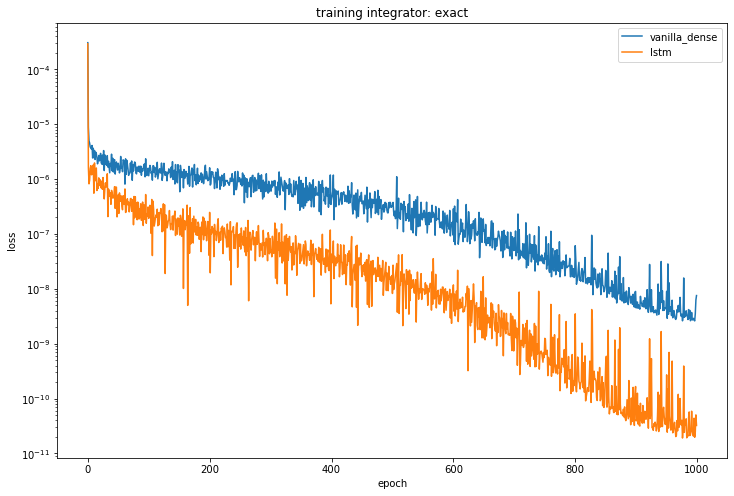

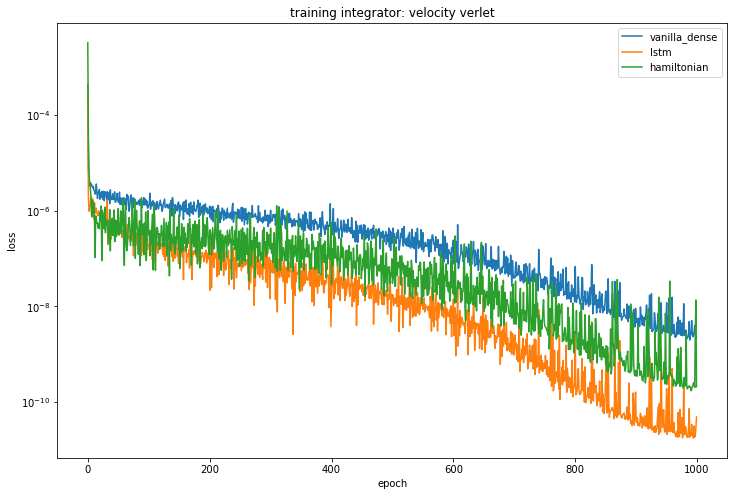

In [9]:
# Train with exact training data?
use_exact_training = False

for use_exact_training in (True,False):
    plt.figure(figsize=(12, 8))
    import pandas as pd
    if use_exact_training:
        models = ('vanilla_dense', 'lstm')
    else:
        models = ('vanilla_dense', 'lstm','hamiltonian')
    for loss in models:
        if use_exact_training:
            filename = 'loss_history_'+loss+'_exact_training_40x_6steps.csv'
            label = 'exact'
        else:
            filename = 'loss_history_'+loss+'_40x_6steps.csv'
            label = 'velocity verlet'
        data = pd.read_csv(filename)
        X = data['Step'].to_numpy()
        Y = data['Value'].to_numpy()
        plt.title('training integrator: '+label)
        plt.plot(X,Y,label=loss)
    ax = plt.gca()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_yscale('log')
    plt.legend(loc='upper right')
    plt.show()

## Plot trajectories and energy drift

Visualise the position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ for the following setups:

1. Verlet integrator with timestep $\Delta t_{\text{train}}$
2. Coarse Verlet integrator with timestep $\Delta t = 40\Delta t_{\text{train}}$
3. Vanilla dense network with timestep $\Delta t = 40\Delta t_{\text{train}}$
4. LSTM network with timestep $\Delta t = 40\Delta t_{\text{train}}$

For all four setups, also visualise the energy drift $E(t)-E(t=0)$.

Note that this will load the trained models from disk, so this will only work if you have these files (I didn't commit them to the repository since they are very large).

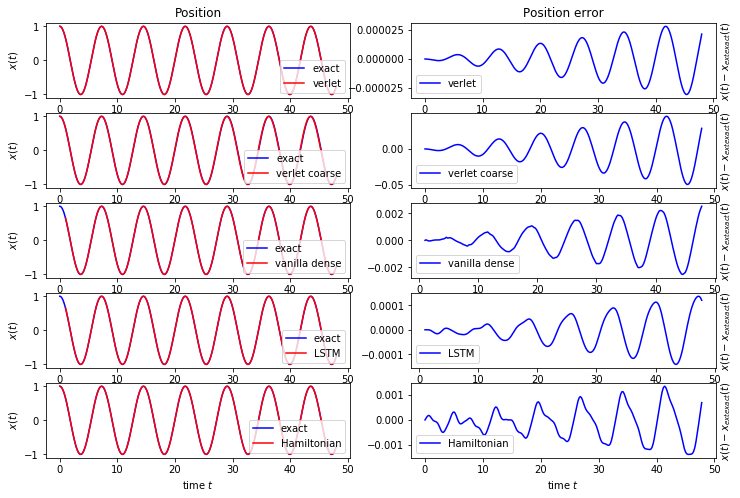

<Figure size 432x288 with 0 Axes>

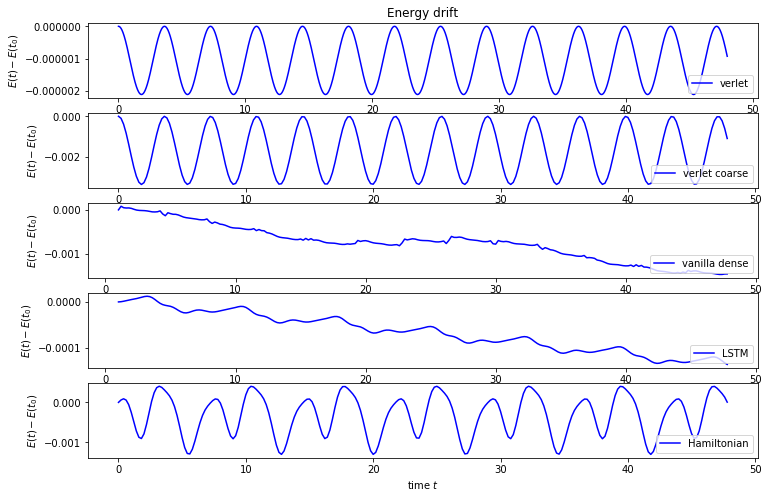

In [20]:
# Final time
T_final = 48

# Initial conditions
x0 = np.zeros(1)
v0 = np.zeros(1)
x0[0] = 1.0
v0[0] = 0.0
verlet_integrator = VerletIntegrator(dynamical_system,dt_train)
verlet_integrator.set_state(x0,v0)
exact_integrator = ExactIntegrator(dynamical_system,dt_train)
exact_integrator.set_state(x0,v0)

# ==== Verlet- and exact integrator ====
t0 = 0.0
t = {} # times
x = {} # positions
E = {} # energies
dx = {} # position errors
t['exact'] = []
t['verlet'] = []
x['exact'] = []
x['verlet'] = []
E['exact'] = []
E['verlet'] = []
dx['verlet'] = []
while t0<T_final:
    t['exact'].append(t0)
    t['verlet'].append(t0)
    E['exact'].append(exact_integrator.energy())
    x['exact'].append(exact_integrator.x[0])
    E['verlet'].append(verlet_integrator.energy())
    x['verlet'].append(verlet_integrator.x[0])
    dx['verlet'].append(verlet_integrator.x[0]-exact_integrator.x[0])
    verlet_integrator.integrate(1)
    exact_integrator.integrate(1)
    t0 += dt_train

# Verlet with large timestep

t['verlet coarse'] = []
x['verlet coarse'] = []
E['verlet coarse'] = []
dx['verlet coarse'] = []
coarse_verlet_integrator = VerletIntegrator(dynamical_system,dt)
coarse_verlet_integrator.set_state(x0,v0)
exact_integrator.set_state(x0,v0)
t0 = 0.0
nsteps = int(dt/dt_train)
while t0<T_final:
    t['verlet coarse'].append(t0)
    E['verlet coarse'].append(coarse_verlet_integrator.energy())
    x['verlet coarse'].append(coarse_verlet_integrator.x[0])
    dx['verlet coarse'].append(coarse_verlet_integrator.x[0]-exact_integrator.x[0])
    coarse_verlet_integrator.integrate(1)
    exact_integrator.integrate(nsteps)
    t0 += dt

# ==== Neural network integrators ====

models = {'vanilla dense':keras.models.load_model('vanilla_dense_40x_6steps'),
          'LSTM':keras.models.load_model('lstm_40x_6steps'),
          'Hamiltonian':HamiltonianNNIntegrator.load_model('hamiltonian_40x')}
for label,model in models.items():
    nn_integrator = NNIntegrator.from_model(dynamical_system,dt,model)
    # Initialise with exact integrator
    x_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    v_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    exact_integrator.set_state(x0,v0)
    for k in range(nn_integrator.nsteps):    
        x_initial[k,:] = exact_integrator.x[:]
        v_initial[k,:] = exact_integrator.v[:]
        exact_integrator.integrate(int(dt/dt_train))
        nsteps += 1
    nn_integrator.set_state(x_initial,v_initial)
    t0 = (nn_integrator.nsteps-1)*nn_integrator.dt
    
    # Timestepping loop
    t[label] = []
    x[label] = []
    E[label] = []
    dx[label] = []
    nsteps = (nn_integrator.nsteps-1)*int(dt/dt_train)
    while t0<T_final:
        t[label].append(t0)
        x_nn = nn_integrator.x[0]
        exact_integrator.set_state(x0,v0)
        exact_integrator.integrate(nsteps)
        x_exact = exact_integrator.x[0]
        x[label].append(x_nn)
        dx[label].append(x_nn-x_exact)
        E[label].append(nn_integrator.energy())
        nn_integrator.integrate(1)
        t0 += dt
        nsteps += int(dt/dt_train)

# Plot position as a function of time
fig, axs = plt.subplots(5,2,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j][0] 
    ax.plot(t['exact'],x['exact'],label='exact',color='blue')
    ax.plot(t[label],x[label],label=label,color='red')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)$')
    if j==0:
        ax.set_title('Position')
    ax = axs[j][1] 
    ax.plot(t[label],np.asarray(dx[label]),label=label,color='blue')
    ax.legend(loc='lower left')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)-x_{\text{exact}}(t)$')
    ax.yaxis.set_label_position("right")
    if j==0:
        ax.set_title('Position error')
plt.show()

plt.clf()
fig, axs = plt.subplots(5,1,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j]
    ax.plot(t[label],np.asarray(E[label])-E[label][0],label=label,color='blue')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$E(t)-E(t_0)$')
    if j==0:
        ax.set_title('Energy drift')
plt.show()

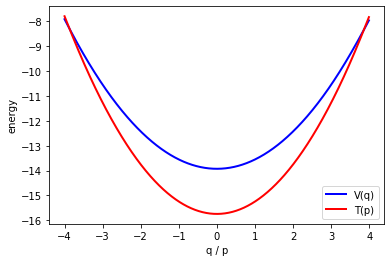

In [25]:
# Plot potential and kinetic energy (for debugging, can only be used with Hamiltonian network)
model = HamiltonianNNIntegrator.load_model('hamiltonian_40x')
    
X = tf.expand_dims(tf.constant(np.arange(-4.0,4.0,0.01)),axis=1)

V_pot = model.layers[-1].V_pot(X).numpy().flatten()
T_kin = model.layers[-1].T_kin(X).numpy().flatten()
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='lower right')
plt.show()